In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

In [35]:
#variables to modify
n_sensors = 37 #number of sensors

#header of the timestamp column
time_header = "Timestamp (Local)" 

#names of the folders where the data is stored
folder_name = 'level1_data'
first_timestamp = "12/31/2023 06:00:00"
last_timestamp = "01/08/2024 05:00:00" #--fill data if there are missing values between these timestamps

#set the parameter you want to harmonize; 
#the parameter name should be exactly the same as in the headers in the csv files, written in a list, ex. ["PM 2.5", "PM 1.0", "CO2"]
parameters = ["PM 1.0", "PM 2.5", "PM 4.0", "PM 10"]

In [49]:
#read data
data = []

#read data from the sensors
data = [pd.read_csv(f'{folder_name}/BlueSky' + str(i+1) + '.csv') for i in range(n_sensors)]

#dropping unit rows
data = [data[i].drop([0]) for i in range(n_sensors)]
data = [data[i].drop(columns=["Timestamp"]) for i in range(n_sensors)]

sensor_names = [f'BlueSky {i+1}' for i in range(n_sensors)]

print("checking the lengths of the sensor data:")
u = [len(data[i].index) for i in range(n_sensors)]
print(u)

#---------------------------------------
#convert the timestamps to datetime type
for i in range(n_sensors):
    data[i][time_header] = pd.to_datetime(data[i][time_header]).round('1H')

for parameter in parameters:
    for i in range(n_sensors):
        data[i][parameter] = pd.to_numeric(data[i][parameter], errors='coerce')

#set the timestamps as index
start = pd.to_datetime(first_timestamp)
end = pd.to_datetime(last_timestamp)
dates = pd.date_range(start=start, end=end, freq='1H')

#fill the missing values with nan
data = [data[i].set_index(time_header).reindex(dates).reset_index()  for i in range(n_sensors)]

#create a folder to save results of harmonization
result_folder = 'harmonization_results'
level2_folder = 'level2_data'
if not os.path.isdir(result_folder):
    os.makedirs(f'./{result_folder}/{level2_folder}')

checking the lengths of the sensor data:
[192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 191, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192]


In [50]:
def harmonize(parameter):

    #finding the median values for each timestamp - 'parameter_data' is 2-dimensional arrays to store the values of the parameter for all sensors
    parameter_data = [data[i][parameter].values for i in range(n_sensors)]
    
    #cut off sensors with missing days to find the median in a simpler way
    parameter_data = np.array([parameter_data[i] for i in range(n_sensors)])
    median = np.nanmedian(parameter_data, axis=0)

    print(parameter_data)
    #-------------------------------------------------
    #for plotting
    figure, axis = plt.subplots(5, n_sensors//5+1)

    #for regression
    def func(x, a, b):
        return a*x + b

    #to save calibration factors
    calibration_factors = np.zeros(n_sensors)
    #to save harmonized data
    harmonized_data = np.zeros((n_sensors, len(median)))

    x = median
    print(f'calculating harmonization data for {parameter} ...')
    for i in range(n_sensors):
        #plot the sensors' data against the median (the values are centralized to zero)
        axis[i%5, i//5].plot(median, data[i][parameter], 'o')
        axis[i%5, i//5].set_title(f"Sensor {sensor_names[i]}")
        axis[i%5, i//5].set_xlabel("median")

        #regression for slope
        y = data[i][parameter].values
        
        #to omit values with nan
        valid = ~ (np.isnan(x) | np.isnan(y))

        #regression (the values are centralized to zero, by setting the intercept to zero)
        popt, pcov = curve_fit(func, x[valid], y[valid], bounds=([-np.inf, -0.000001], [np.inf, 0.000001]))
        calibration_factors[i] = round(1/popt[0], 2)

        #r2 value
        residuals = y[valid] - func(x[valid], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y[valid]-np.mean(y[valid]))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        #plot the regression line
        axis[i%5, i//5].plot(x, func(x, *popt), 'r--')
        axis[i%5, i//5].text(0.1, 0.9, f"y={popt[0].round(2)}x", transform=axis[i%5, i//5].transAxes)
        axis[i%5, i//5].text(0.1, 0.8, f"r2={r_squared.round(2)}", transform=axis[i%5, i//5].transAxes)

    
    #increase the plot's size
    figure.set_size_inches(16.5, 16.5)
    
    plt.suptitle(f"{parameter} Harmonization", fontsize=16)
    plt.tight_layout()
    
    plt.savefig(f'{result_folder}/{parameter}_calibration_fitting.png', dpi=300)
    #plt.show()

    #
    #plots
    #plot the parameter vs time, truncating before 408
    plt.figure(figsize=(16,9))
    plt.plot(dates[:], median[:], label="median")
    for i in range(n_sensors):
        plt.plot(dates[:], data[i][parameter].iloc[:]*calibration_factors[i], label=f"sensor {sensor_names[i]}")

    #to save the harmonized data in a variable
    for i in range(n_sensors):
        harmonized_data[i][:] = data[i][parameter]*calibration_factors[i]

    #cosmetics of the plot
    plt.xlabel("Date", fontsize=16)
    plt.ylabel(parameter, fontsize=16)
    plt.legend(loc="upper right", fontsize=7)
    plt.title(f"{parameter} Harmonization", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{result_folder}/{parameter}_calibration.png', dpi=300)
    #plt.show()

    return calibration_factors, harmonized_data


[[27. 23. 21. ... 25. 24. 22.]
 [13. 11. 10. ... 13. 12. 12.]
 [12. 11. 10. ... 12. 11. 11.]
 ...
 [27. 24. 22. ... 26. 25. 24.]
 [11. 10.  9. ... 11. 10. 10.]
 [34. 30. 27. ... 33. 31. 29.]]
calculating harmonization data for PM 1.0 ...
[[29. 26. 24. ... 27. 26. 24.]
 [14. 12. 11. ... 14. 13. 12.]
 [13. 12. 11. ... 13. 12. 12.]
 ...
 [29. 26. 24. ... 28. 26. 26.]
 [12. 11. 10. ... 12. 11. 11.]
 [37. 32. 29. ... 35. 33. 31.]]
calculating harmonization data for PM 2.5 ...
[[31. 26. 24. ... 27. 26. 25.]
 [15. 12. 12. ... 14. 13. 12.]
 [14. 12. 11. ... 13. 12. 12.]
 ...
 [30. 26. 25. ... 28. 27. 26.]
 [13. 11. 10. ... 12. 11. 11.]
 [38. 33. 30. ... 35. 33. 32.]]
calculating harmonization data for PM 4.0 ...
[[31. 27. 25. ... 28. 26. 25.]
 [15. 13. 12. ... 14. 13. 12.]
 [14. 12. 11. ... 13. 12. 12.]
 ...
 [30. 27. 25. ... 28. 27. 26.]
 [13. 11. 10. ... 12. 11. 11.]
 [38. 33. 30. ... 35. 34. 32.]]
calculating harmonization data for PM 10 ...


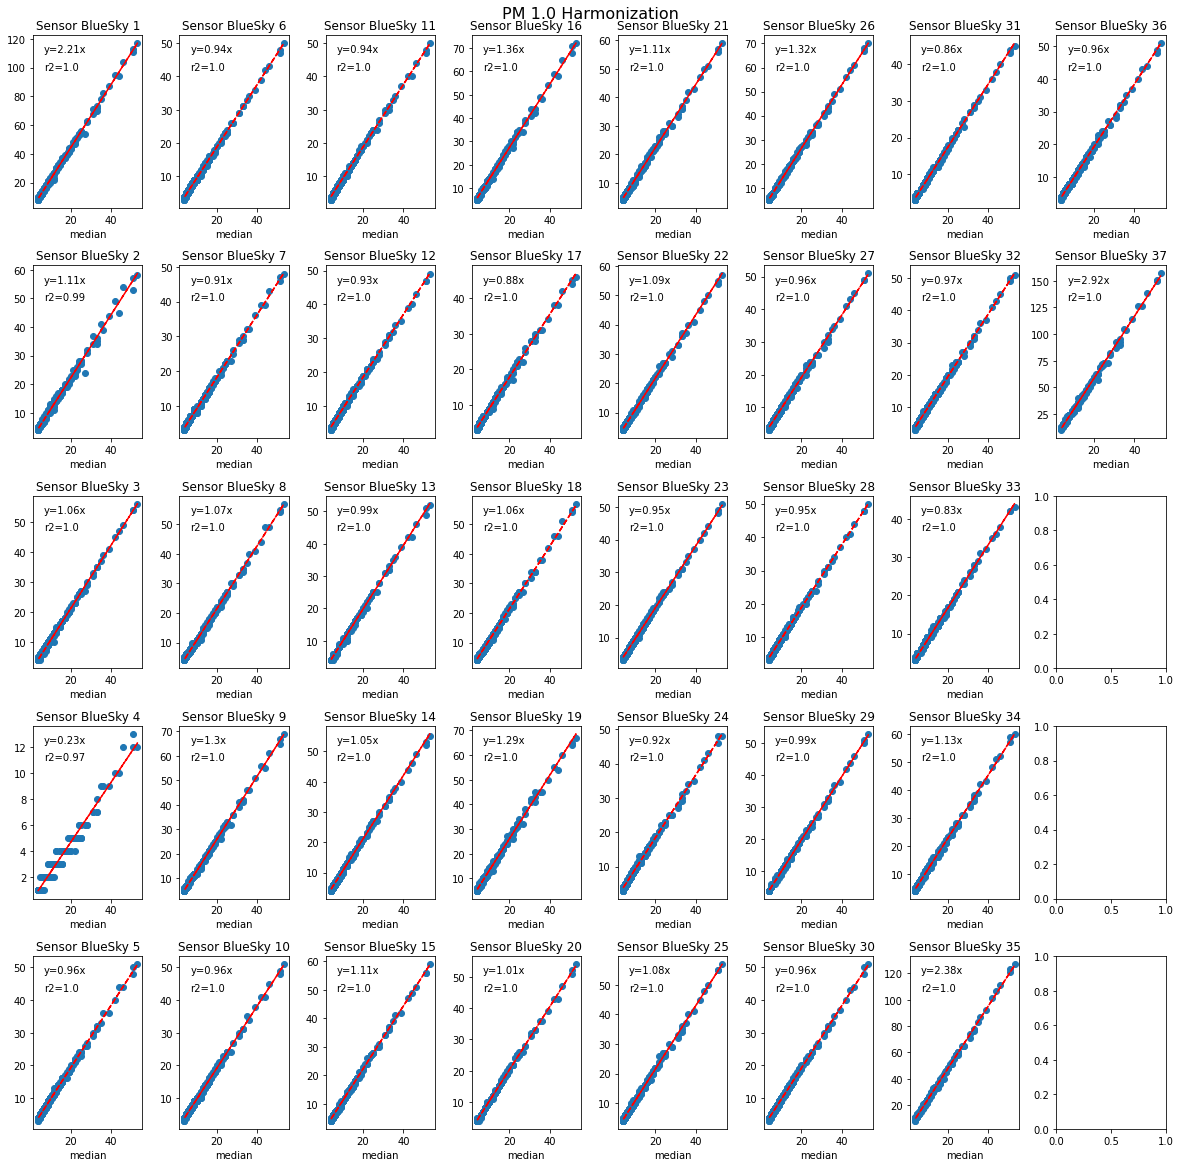

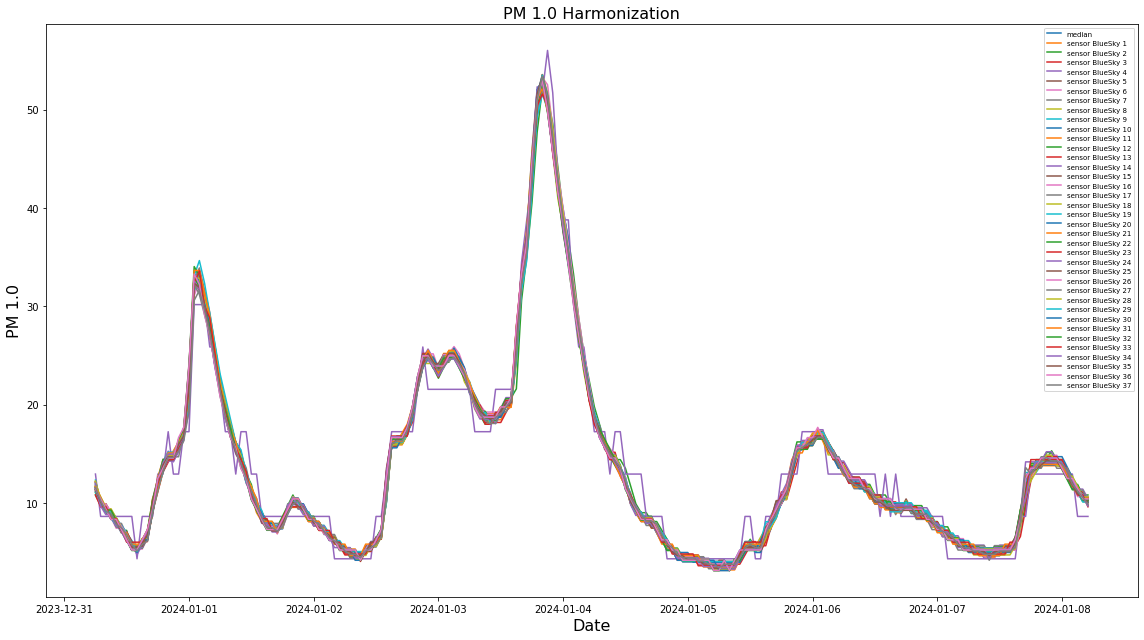

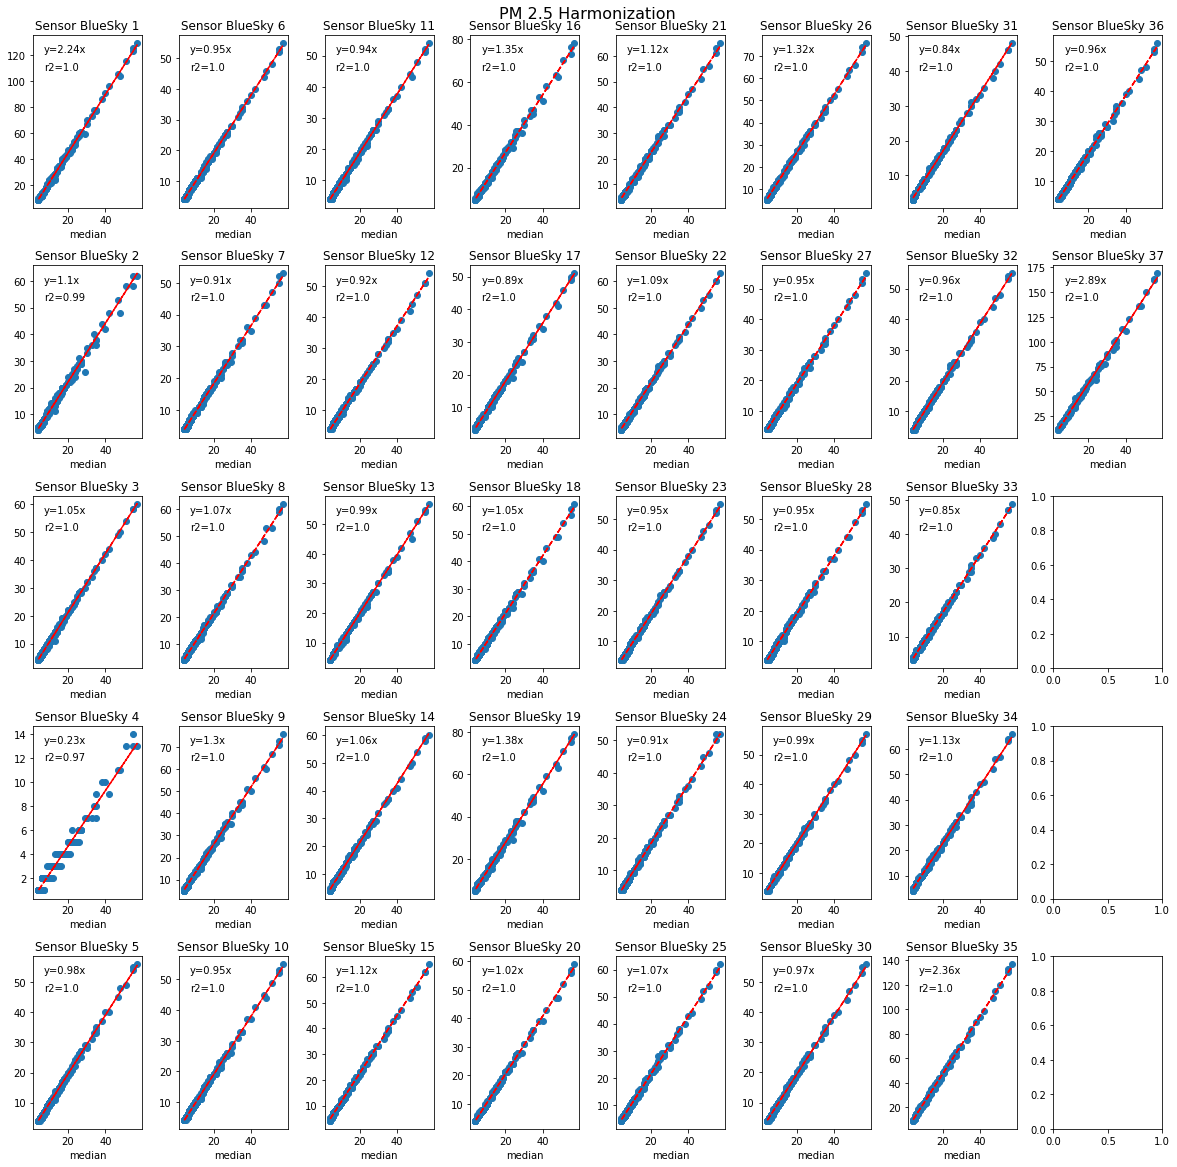

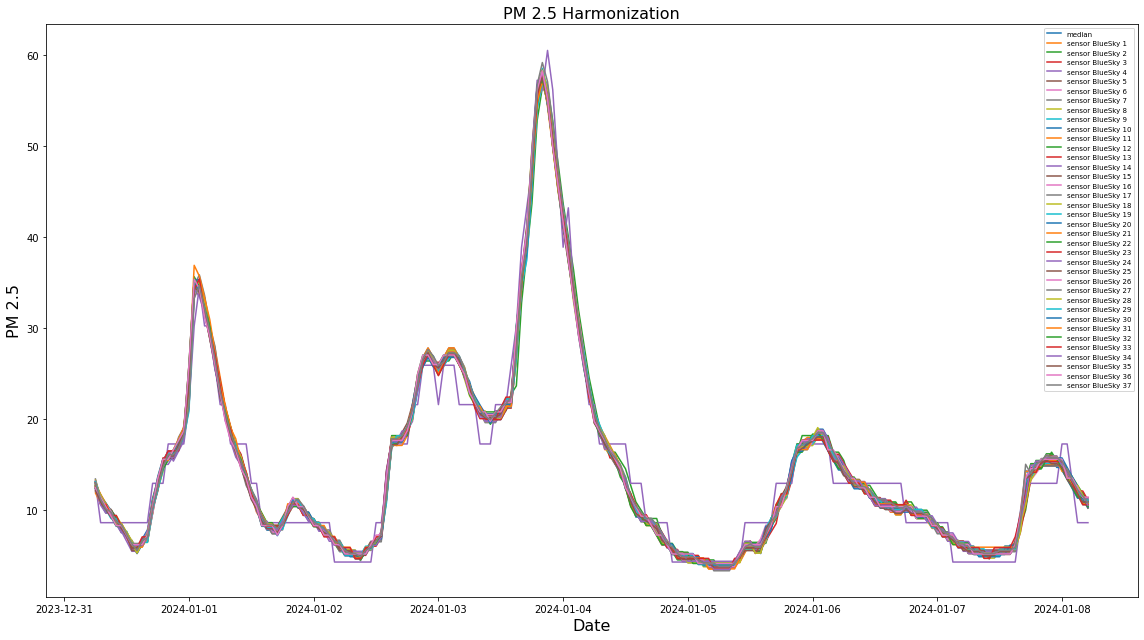

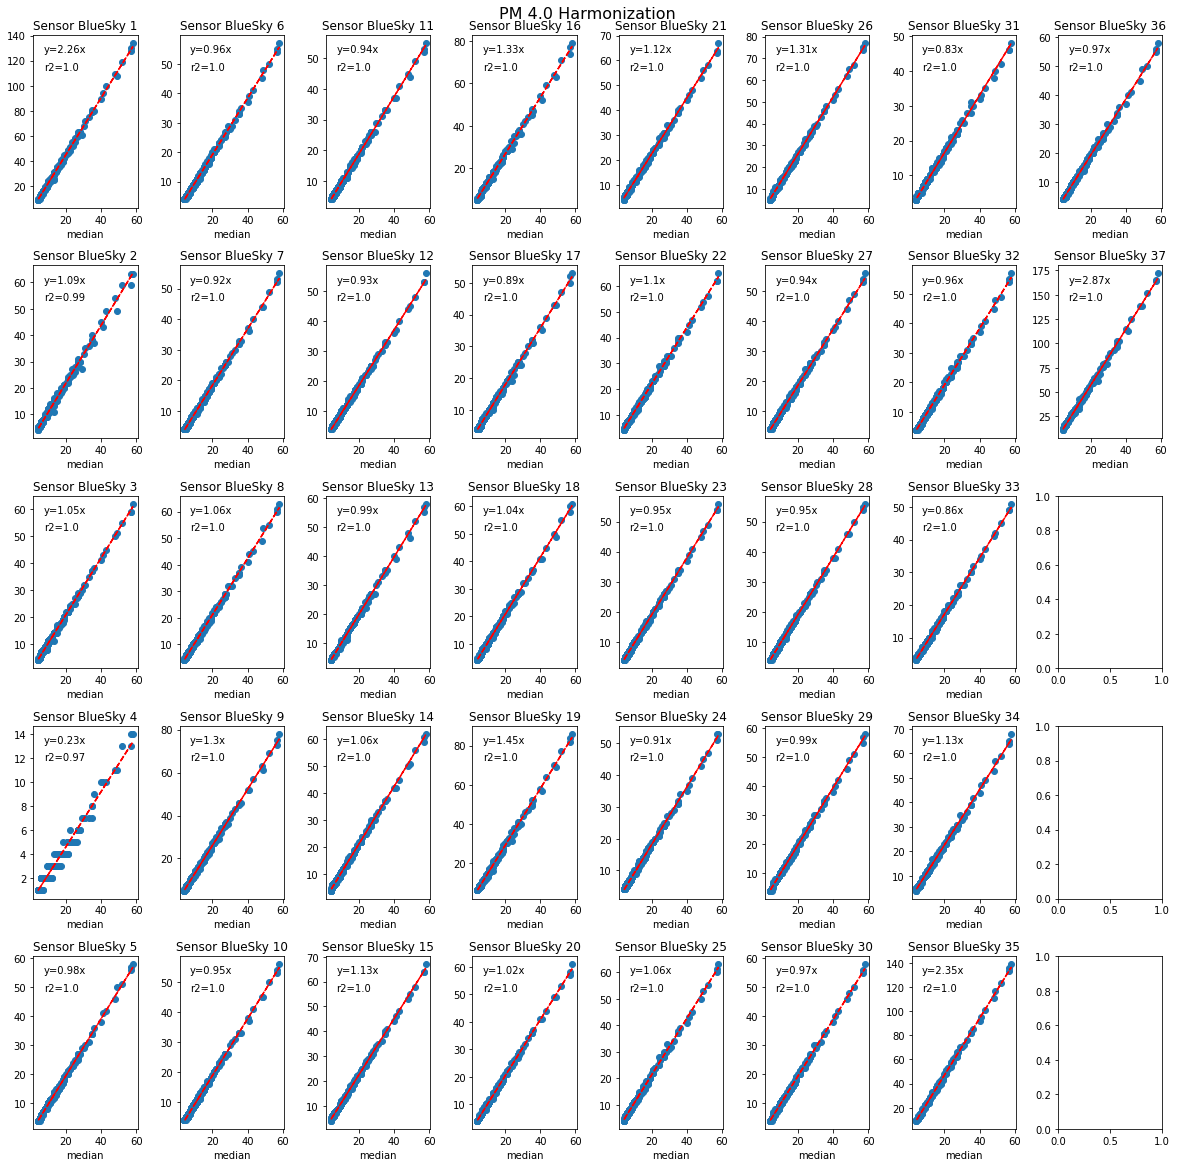

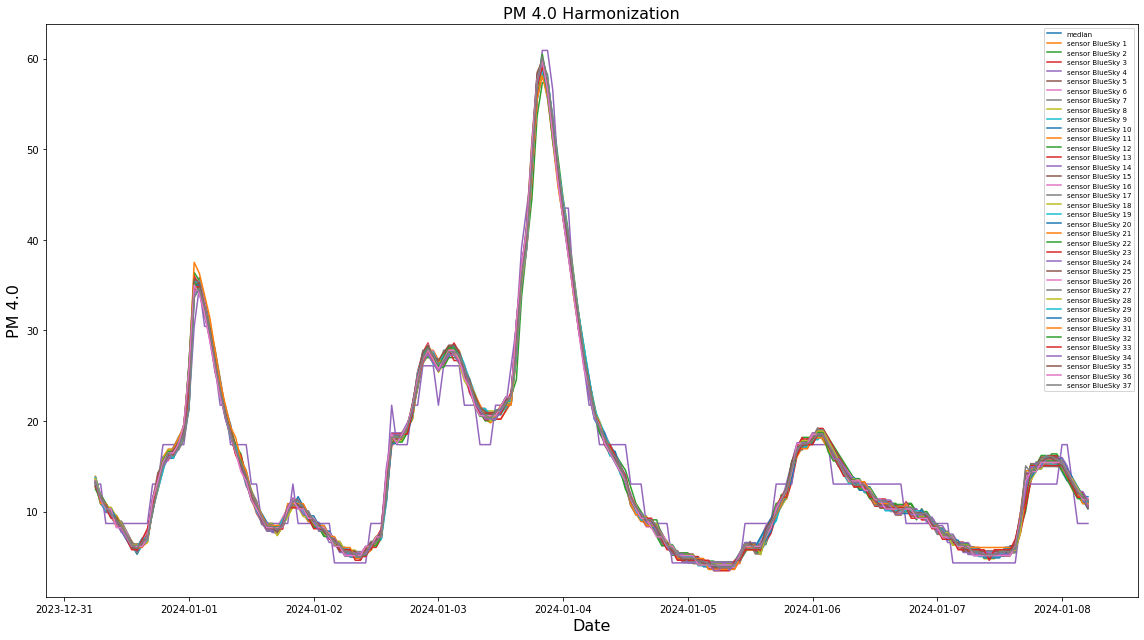

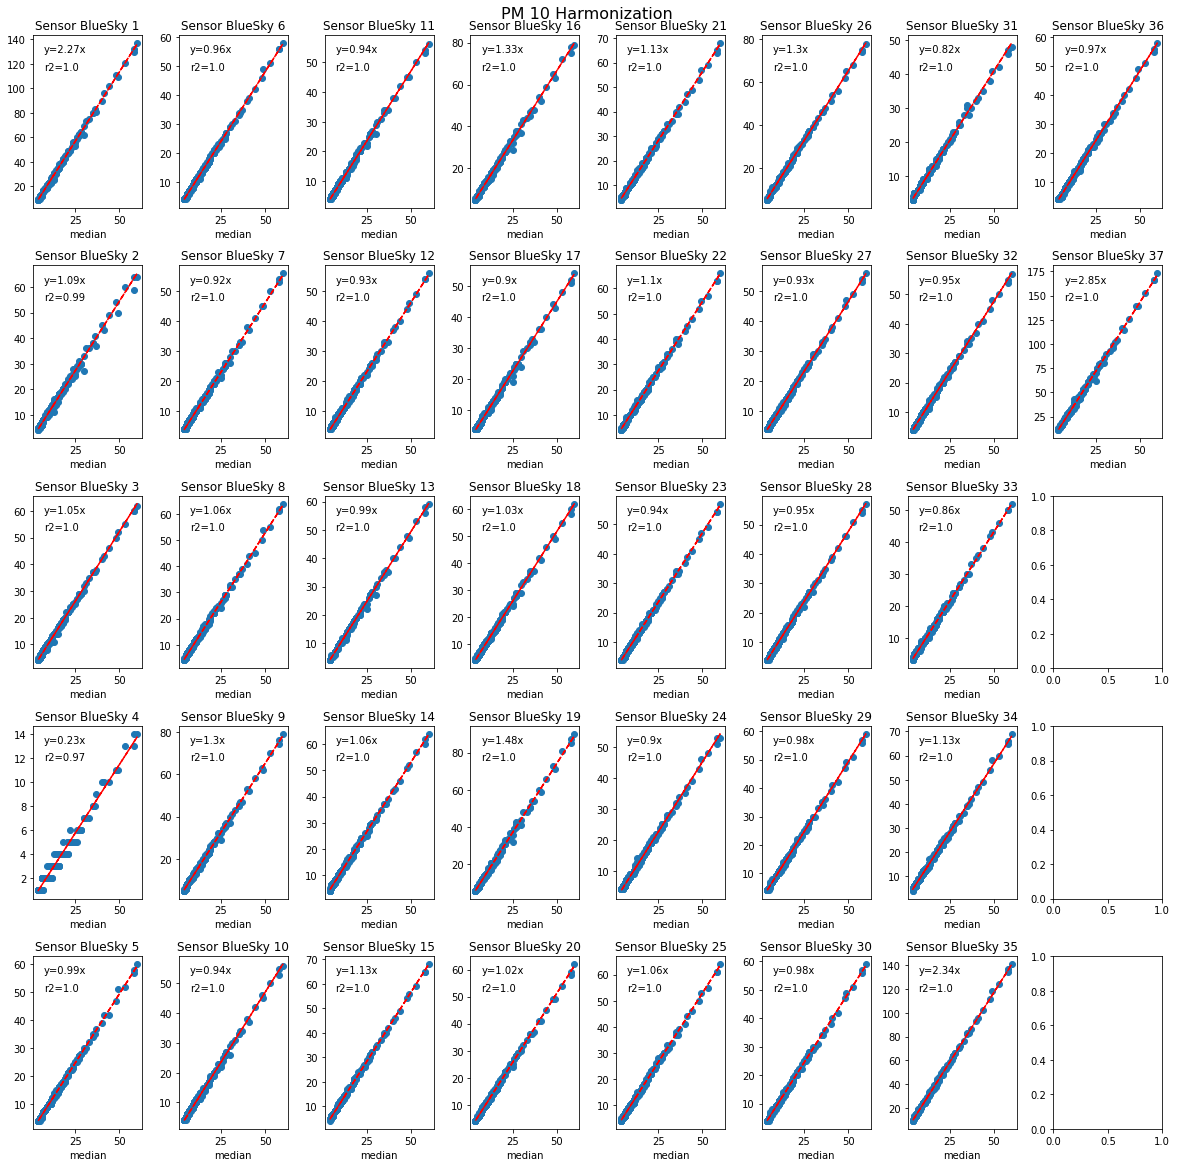

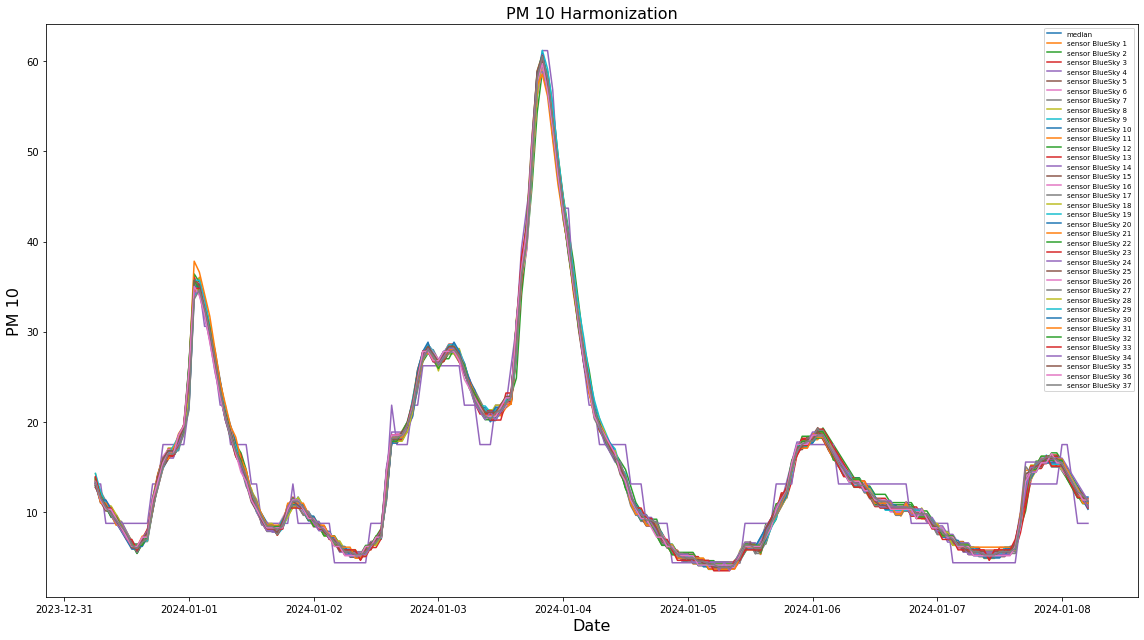

In [51]:
#get the data from harmonization
res_data = [harmonize(p) for p in parameters]

In [52]:
#get calibration factors and harmonized data
calibration_factors = [res_data[i][0] for i, _ in enumerate(parameters)]
harmonized_data = [res_data[i][1] for i, _ in enumerate(parameters)]

#save the harmonized data in csv files, in level2_* folder
for i in range(n_sensors):
    sensor_harmonized_data = np.vstack([harmonized_data[j][i] for j, _ in enumerate(parameters)]) 
    sensor_harmonized_dataframe = pd.DataFrame(sensor_harmonized_data.T, columns=parameters)
    sensor_harmonized_dataframe.insert(0, time_header, dates)
    sensor_harmonized_dataframe.to_csv(f'{result_folder}/{level2_folder}/{sensor_names[i]}.csv', index=False)

#save the calibration factors in a csv file
for i, parameter in enumerate(parameters):
    if i == 0:
        df_calibration_factors = pd.DataFrame(calibration_factors[i], columns=[f"{parameter} CF"])
        df_calibration_factors.insert(0, "sensor", sensor_names)
        df_calibration_factors.to_csv(f'{result_folder}/calibration_factors.csv', index=False)
    else:
        df_calibration_factors = pd.read_csv(f'{result_folder}/calibration_factors.csv')
        df_calibration_factors[f"{parameter} CF"] = calibration_factors[i]
        df_calibration_factors.to_csv(f'{result_folder}/calibration_factors.csv', index=False)


In [53]:
#metadata of the calibration factors
pm25_cf = calibration_factors[1]
cf_median, cf_mean, cf_min, cf_max = np.nanmedian(pm25_cf), np.mean(pm25_cf), np.min(pm25_cf), np.max(pm25_cf)
cf_10_perc, cf_90_perc = np.percentile(pm25_cf, 10), np.percentile(pm25_cf, 90)

print("for PM2.5 HF:")
print(f"median is {cf_median}; mean is {cf_mean.round(2)}")
print(f"10the percentile is {cf_10_perc.round(2)}; 90the percentile is {cf_90_perc.round(2)}")
print(f"min is {cf_min}; max is {cf_max}")
#TODO
#for the universal code
#set protocol for the name of the csv files

for PM2.5 HF:
median is 1.01; mean is 1.03
10the percentile is 0.73; 90the percentile is 1.11
min is 0.35; max is 4.32


In [54]:
calibration_factors

[array([0.45, 0.9 , 0.94, 4.31, 1.04, 1.06, 1.1 , 0.93, 0.77, 1.05, 1.06,
        1.08, 1.01, 0.95, 0.9 , 0.74, 1.13, 0.94, 0.77, 0.99, 0.9 , 0.92,
        1.05, 1.09, 0.93, 0.76, 1.04, 1.06, 1.01, 1.04, 1.16, 1.03, 1.2 ,
        0.88, 0.42, 1.04, 0.34]),
 array([0.45, 0.91, 0.95, 4.32, 1.03, 1.05, 1.09, 0.94, 0.77, 1.05, 1.07,
        1.08, 1.01, 0.94, 0.89, 0.74, 1.12, 0.95, 0.72, 0.98, 0.89, 0.91,
        1.05, 1.1 , 0.93, 0.76, 1.06, 1.06, 1.01, 1.03, 1.19, 1.04, 1.18,
        0.88, 0.42, 1.04, 0.35]),
 array([0.44, 0.91, 0.95, 4.35, 1.02, 1.04, 1.09, 0.94, 0.77, 1.06, 1.07,
        1.08, 1.01, 0.94, 0.89, 0.75, 1.12, 0.96, 0.69, 0.98, 0.89, 0.91,
        1.06, 1.1 , 0.94, 0.77, 1.07, 1.05, 1.01, 1.03, 1.21, 1.04, 1.16,
        0.88, 0.43, 1.03, 0.35]),
 array([0.44, 0.92, 0.96, 4.37, 1.01, 1.04, 1.08, 0.95, 0.77, 1.06, 1.06,
        1.08, 1.01, 0.94, 0.88, 0.75, 1.12, 0.97, 0.68, 0.98, 0.89, 0.91,
        1.06, 1.11, 0.94, 0.77, 1.07, 1.05, 1.02, 1.03, 1.22, 1.05, 1.16,
        0.

In [ ]:
#TODO
#for the universal code
#set protocol for the name of the csv files